# Using Metadensity with PAR-CLIP
This notebook showcases use cases on PAR-CLIP

In [1]:
# set up files associated with each genome coordinates
import metadensity as md
md.settings.from_config_file('/home/hsher/projects/Metadensity/config/mm10.ini')


# then import the modules
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# I have a precompiles list of ENCODE datas as a csv that loads in this dataloader
import sys
sys.path.append('/home/hsher/projects/Metadensity/scripts')

plt.style.use('seaborn-white')

please set the right config according to genome coordinate
Using /projects/ps-yeolab3/bay001/annotations/mm10/mm10.fa
Using:  /home/hsher/gencode_coords/gencode.vM25.transcript.gff3


## I downloaded some PAR-CLIP from the internet.
[Link to GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE154732)

[Link to paper](https://academic.oup.com/nar/article/50/5/2587/6523806?login=false)

They PAR-CLIPped histone deacetylase from mouse stem cells.

Here I show how you load data.

Since there is no strand specific bigwigs, I am going to both strands (`plus`,`minus`) to the same bw

In [2]:
from pathlib import Path
indir = Path('/home/hsher/scratch/parclip_data')

ip_rep1 = str(indir/'GSM4677992_PARCLIP_p300_mESC_Rep1.dedup.filt.bw')
ip_rep2 = str(indir/'GSM4677993_PARCLIP_p300_mESC_Rep2.dedup.filt.bw')

igg_rep1 = str(indir/'GSM4677994_PARCLIP_IgG_mESC_Rep1.dedup.filt.bw')
igg_rep2 = str(indir/'GSM4677995_PARCLIP_IgG_mESC_Rep2.dedup.filt.bw')

data = {'minus_0':ip_rep1,
 'plus_0':ip_rep1, # data on GEO is not processed in a strand specific manner
 'minus_1': ip_rep2,
 'plus_1': ip_rep2,
 'minus_control_0': igg_rep1,
 'plus_control_0': igg_rep1,
 'minus_control_1':igg_rep2,
 'plus_control_1':igg_rep2,
        'RBP': 'p300',
        'uid': 'p300'
}

data_series = pd.Series(data)

In [3]:
data_series.apply(os.path.isfile)

minus_0             True
plus_0              True
minus_1             True
plus_1              True
minus_control_0     True
plus_control_0      True
minus_control_1     True
plus_control_1      True
RBP                False
uid                False
dtype: bool

In [4]:
parclip = eCLIP.from_series(data_series)

warning no bam file!
warning no bam file!
warning no bam file!
warning no bam file!


In [5]:
clips = [parclip]

# Calulcate Density and Truncation sites
Object `Metatruncation` and `Metadensity` takes three things:
1. an experiment object `eCLIP` or `STAMP`.
2. a set of transcript pyBedTools that you want to plot on
3. name of the object

Options include:
1. `sample_no=` allows you to decide how many transcript you want to build the density. It will take longer. By default, `sample_no=200`. So in transcript if you give more than 200 transcripts, only 200 will be used
2. `metagene` allows you to use pre-built metagene. This feature is more useful when you want to compare the same set of RNA over many RBPs.
3. `background_method` handles how you want to deal with IP v.s. Input
4. `normalize` handles how you want to normalize values within a transcript.

## Difference between truncation and density

`Metadensity` represents read coverage. `Metatruncation` represents the 5' end of read 2 for `eCLIP`; edit sites for `STAMP`.

# Now we need to decide a set of transcripts to plot the metagene: start with p300's target
the paper's supplementary table 1 has a list of p300 PAR-CLIP targets. [Download here](https://academic.oup.com/nar/article/50/5/2587/6523806?login=false#supplementary-data)

In [6]:
p300_nuclear_targets = pd.read_excel('/home/hsher/scratch/parclip_data/gkac083_supplemental_files/Supplementary Table S1_p300PAR-CLIP_NuclearAssociatedTranscriptsxlsx.xlsx',
             engine = 'openpyxl')
p300_target_gene_id = p300_nuclear_targets['gene_id'].unique().tolist()

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [7]:
# 
p300_targets_transcripts = transcript.filter(lambda t: t.attrs['gene_id'] in p300_target_gene_id).saveas()

In [8]:
len(p300_targets_transcripts ) # we found 1209 of them

1209

In [9]:
# this step takes some time for building metagene from the annotation files.
p300_targets_meta = Metadensity(parclip, 'p300 on its targets',
                                transcripts = p300_targets_transcripts,
                                background_method = 'relative information', 
                                normalize = True)
p300_targets_meta.get_density_array()


Using: /home/hsher/projects/Metadensity/metadensity/data/mm10/gencode
Done building metagene


/projects/ps-yeolab3/hsher/Metadensity/metadensity/metadensity.py:930: RuntimeWarning: invalid value encountered in true_divide
  values = values/np.sum(values)
/projects/ps-yeolab3/hsher/Metadensity/metadensity/metadensity.py:987: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


## Visualize RBP map: individual density per transcript

use `feature_to_show` to decide what features to show. 

/projects/ps-yeolab3/hsher/Metadensity/metadensity/plotd.py:187: RuntimeWarning: Mean of empty slice
  density_concat = np.nanmean(np.stack([den_arr[feat,align, r] for r in m.eCLIP.rep_keys]), axis = 0)


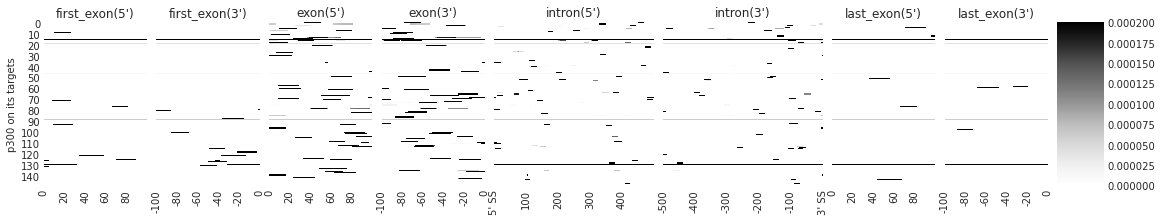

In [10]:
### PLOT INDIVIDUAL DENSITY
# you can customize the list of features you want to show. This is suitable when you are looking for splicing
f = plot_rbp_map([p300_targets_meta], features_to_show = generic_rna, ymax = 0.0002)

Text(0, 0.5, 'mean relative information')

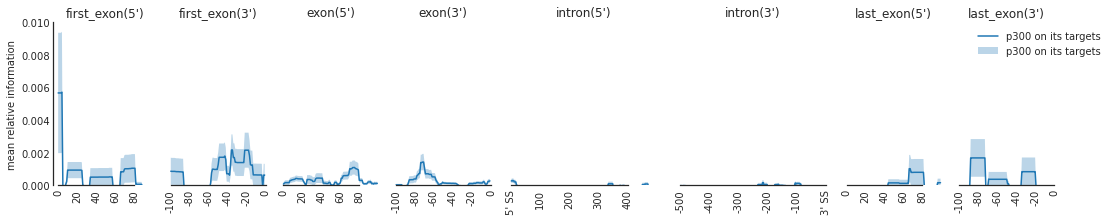

In [11]:
f=plot_mean_density([p300_targets_meta],
                    features_to_show = generic_rna, ymax = 0.01)
f=beautify(f, offset = 0) # sns.despine 
f.get_axes()[0].set_ylabel('mean relative information')
#f.savefig('SF3B4_rna.svg', dpi = 300)

# The paper also compares RNA expression of WT ESCs with lncSmad7 KO
let's see if p300 binds different places on these differentially expressed genes

In [12]:
deseq = pd.read_excel('/home/hsher/scratch/parclip_data/gkac083_supplemental_files/Supplementary Table S2_RNA-seq_DifferentiallyExpressedGenes.xlsx',
             engine = 'openpyxl', skiprows = 1)

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [13]:
deseq.head()
deseq.columns = ['GeneID', 
                'significance_kosmad7',
                 'significance_rescue',
                 'significance_wt', # compare to KO
                 'l2fc_kosmad7',
                 'l2fc_rescue',
                 'l2fc_wt',
                 'lfpkm_ko',
                 'lfpkm_kosmad7',
                 'lfpkm_rescue',
                 'lfpkm_wt',
                 'pval_wt',
                 'padj_wt'
                ]
deseq['-log10pval'] = -np.log10(deseq['pval_wt'])

/home/hsher/miniconda3/envs/Metadensity/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='l2fc_wt', ylabel='-log10pval'>

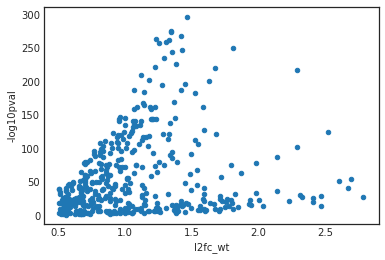

In [14]:
deseq.plot.scatter(x = 'l2fc_wt', y = '-log10pval')

In [15]:
de_genenames = deseq.loc[(deseq['l2fc_wt']>1)&(deseq['-log10pval']>3), 'GeneID'].tolist()
nochange_genenames = list(set(deseq['GeneID'].dropna())-set(de_genenames))

de_transcript = transcript.filter(lambda t: t.attrs['gene_name'] in de_genenames).saveas()
nc_transcript = transcript.filter(lambda t: t.attrs['gene_name'] in nochange_genenames).saveas()

In [16]:
len(de_transcript), len(nc_transcript)

(208, 224)

In [17]:
p300_de_meta = Metadensity(parclip, 'p300 on DE genes',
                                transcripts = de_transcript,
                                background_method = 'relative information', 
                                normalize = True)
p300_de_meta.get_density_array()

p300_nc_meta = Metadensity(parclip, 'p300 on NC genes',
                                transcripts = nc_transcript,
                                background_method = 'relative information', 
                                normalize = True)
p300_nc_meta.get_density_array()

Using: /home/hsher/projects/Metadensity/metadensity/data/mm10/gencode
Done building metagene


/projects/ps-yeolab3/hsher/Metadensity/metadensity/metadensity.py:930: RuntimeWarning: invalid value encountered in true_divide
  values = values/np.sum(values)
/projects/ps-yeolab3/hsher/Metadensity/metadensity/metadensity.py:987: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


Using: /home/hsher/projects/Metadensity/metadensity/data/mm10/gencode
Done building metagene
need at least one array to concatenate


Text(0, 0.5, 'mean relative information')

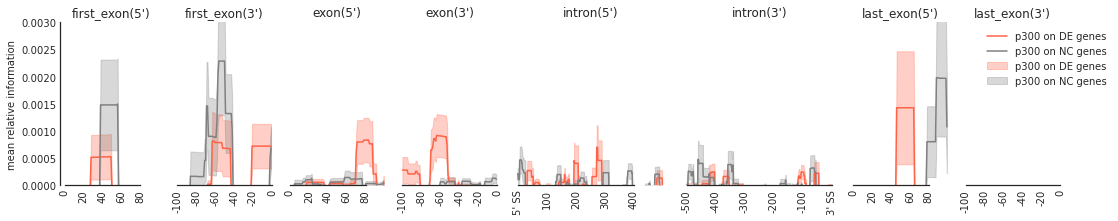

In [18]:
f=plot_mean_density([p300_de_meta, p300_nc_meta],
                    features_to_show = generic_rna, ymax = 0.003,
                   color_dict = {'p300 on NC genes': 'grey',
                                'p300 on DE genes': 'tomato'})
f=beautify(f, offset = 0) # sns.despine 
f.get_axes()[0].set_ylabel('mean relative information')
#f.savefig('SF3B4_rna.svg', dpi = 300)